### DRILL: Improve this gradient boost model

We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [43]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [44]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

In [45]:
df

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,SE,3729.0,7,3.0,4.0,5.0,3.0,6.0,6.0,2.0,1.0,18.0,2.0
8590,SE,3732.0,7,5.0,6.0,4.0,4.0,10.0,6.0,3.0,1.0,15.0,2.0
8591,SE,3743.0,7,4.0,5.0,7.0,6.0,8.0,6.0,3.0,1.0,44.0,2.0
8592,SE,3744.0,7,5.0,8.0,8.0,6.0,9.0,7.0,3.0,1.0,15.0,2.0


In [52]:
# Define outcome and predictors
# Set our outcome to 0 and 1
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

## Original Model

In [53]:
# We'll make 500 iterations, using 2-deep trees, and set our loss function
params = {'n_estimators': 500,
         'max_depth': 2,
         'loss': 'deviance'}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0, 1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0, 0.0] / table_train.loc['All', 'All']

test_tI_errors = table_test.loc[0.0, 1.0] / table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0, 0.0] / table_test.loc['All', 'All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04495933711830597
Percent Type II errors: 0.17922356912689888

Test set accuracy:
Percent Type I errors: 0.06134969325153374
Percent Type II errors: 0.18159509202453988


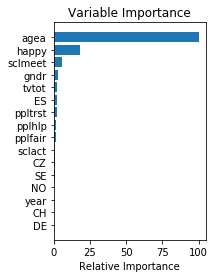

In [54]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Use GridSearchCV to optimize model parameters

### learning_rate shrinks the contribution of each tree
Tune Learning Rate for Gradient Boosting with XGBoost in Python
by Jason Brownlee on September 16, 2016 in XGBoost

A problem with gradient boosted decision trees is that they are quick to learn and overfit training data.

One effective way to slow down learning in the gradient boosting model is to use a learning rate, also called shrinkage (or eta in XGBoost documentation).

* Gradient boosting involves creating and adding trees to the model sequentially.

* New trees are created to correct the residual errors in the predictions from the existing sequence of trees.

* The effect is that the model can quickly fit, then overfit the training dataset.

A technique to slow down the learning in the gradient boosting model is to apply a weighting factor for the corrections by new trees when added to the model. This weighting is called the shrinkage factor or the learning rate, depending on the literature or the tool.

Naive gradient boosting is the same as gradient boosting with shrinkage where the shrinkage factor is set to 1.0. **Setting values less than 1.0 has the effect of making less corrections for each tree added to the model. This in turn results in more trees that must be added to the model.**

It is common to have small values in the range of 0.1 to 0.3, as well as values less than 0.1. A high learning rate can suggest that n_estimators (number of trees) is too low.

### n_estimators represents the number of trees in the forest.
Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the sweet spot.

### max_depth indicates how deep the built tree can be.
The deeper the tree, the more splits it has and it captures more information about how the data. Models tend to overfit the training data at high depth levels (likely in the range of 1-10).

### min_samples_split represents the minimum number of samples required to split an internal node.
This can vary between considering at least one sample at each node to considering all of the samples at each node. When we increase this parameter, the tree becomes more constrained as it has to consider more samples at each node (specify percentage of samples). When we require all of the samples at each node, the model cannot learn enough about the data (underfitting).

### min_samples_leaf is the minimum number of samples required to be at a leaf node.
This similar to min_samples_splits, however, this describe the minimum number of samples at the leafs. Increasing this value can cause underfitting.

### max_features represents the number of features to consider when looking for the best split.
Increasing max_features to consider all of the features often results in an overfitting.

### subsample is used for fitting the individual base learners.
If smaller than 1.0 this results in Stochastic Gradient Boosting. Subsample interacts with the parameter n_estimators. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.

https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [22]:
params = {'loss': ['deviance'],
          'n_estimators': [500 , 1000],
          'learning_rate': [0.001, 0.01, 0.05]
}

gbc = ensemble.GradientBoostingClassifier()
clf = GridSearchCV(gbc, params, cv=3)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'learning_rate': 0.01, 'loss': 'deviance', 'n_estimators': 500}


In [23]:
# Set parameters to optimized values
params = {'loss': 'deviance',
          'n_estimators': 500,
          'learning_rate': 0.01
}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0, 1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0, 0.0] / table_train.loc['All', 'All']

test_tI_errors = table_test.loc[0.0, 1.0] / table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0, 0.0] / table_test.loc['All', 'All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04127666104035599
Percent Type II errors: 0.19610250115083627

Test set accuracy:
Percent Type I errors: 0.04539877300613497
Percent Type II errors: 0.19325153374233128


In [24]:
params = {'loss': ['deviance'],
          'n_estimators': [500],
          'learning_rate': [0.01],
          'max_depth': [2, 4, 6, 8]
}

gbc = ensemble.GradientBoostingClassifier()
clf = GridSearchCV(gbc, params, cv=3)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 500}


In [25]:
# Set parameters to optimized values
params = {'loss': 'deviance',
          'n_estimators': 500,
          'max_depth': 4,
          'learning_rate': 0.01
}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0, 1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0, 0.0] / table_train.loc['All', 'All']

test_tI_errors = table_test.loc[0.0, 1.0] / table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0, 0.0] / table_test.loc['All', 'All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.03851465398189351
Percent Type II errors: 0.18505447291698635

Test set accuracy:
Percent Type I errors: 0.04478527607361963
Percent Type II errors: 0.18834355828220858


In [26]:
params = {'loss': ['deviance'],
          'n_estimators': [500],
          'learning_rate': [0.01],
          'max_depth': [4],
          'subsample': [0.2, 0.5, 1]
}

gbc = ensemble.GradientBoostingClassifier()
clf = GridSearchCV(gbc, params, cv=3)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 500, 'subsample': 0.5}


In [30]:
# Set parameters to optimized values
params = {'loss': 'deviance',
          'n_estimators': 500,
          'max_depth': 4,
          'learning_rate': 0.01,
          'subsample': 0.5
}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0, 1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0, 0.0] / table_train.loc['All', 'All']

test_tI_errors = table_test.loc[0.0, 1.0] / table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0, 0.0] / table_test.loc['All', 'All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.03145619149915605
Percent Type II errors: 0.19840417369955501

Test set accuracy:
Percent Type I errors: 0.03803680981595092
Percent Type II errors: 0.20061349693251534


In [40]:
params = {'loss': ['deviance'],
          'n_estimators': [500],
          'learning_rate': [0.01],
          'max_depth': [4],
          'subsample': [0.5],
          'max_features': [13, 14, 15]
}

gbc = ensemble.GradientBoostingClassifier()
clf = GridSearchCV(gbc, params, cv=3)
clf.fit(X_train, y_train)

print(clf.best_params_)

{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'max_features': 15, 'n_estimators': 500, 'subsample': 0.5}


In [42]:
# Set parameters to optimized values
params = {'loss': 'deviance',
          'n_estimators': 500,
          'max_depth': 4,
          'learning_rate': 0.01,
          'subsample': 0.5,
          'max_features': 15
}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0, 1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0, 0.0] / table_train.loc['All', 'All']

test_tI_errors = table_test.loc[0.0, 1.0] / table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0, 0.0] / table_test.loc['All', 'All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.040355992020868495
Percent Type II errors: 0.18183213134878012

Test set accuracy:
Percent Type I errors: 0.05337423312883435
Percent Type II errors: 0.18220858895705522


## Engineer new feature (interaction between age and happiness)

In [60]:
# Define outcome and predictors
# Set our outcome to 0 and 1
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Make interaction variable
df['age_int_hap'] = df['agea'] * df['happy']

# Add interaction variable to X
X = pd.concat([X, df['age_int_hap']], axis=1)

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [61]:
X

,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,age_int_hap,CH,CZ,DE,ES,NO,SE,age_int_hap
0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,480.0,1,0,0,0,0,0,480.0
1,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,531.0,1,0,0,0,0,0,531.0
2,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,168.0,1,0,0,0,0,0,168.0
3,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,640.0,1,0,0,0,0,0,640.0
4,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,440.0,1,0,0,0,0,0,440.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8589,7,3.0,4.0,5.0,3.0,6.0,6.0,2.0,1.0,18.0,108.0,0,0,0,0,0,1,108.0
8590,7,5.0,6.0,4.0,4.0,10.0,6.0,3.0,1.0,15.0,150.0,0,0,0,0,0,1,150.0
8591,7,4.0,5.0,7.0,6.0,8.0,6.0,3.0,1.0,44.0,352.0,0,0,0,0,0,1,352.0
8592,7,5.0,8.0,8.0,6.0,9.0,7.0,3.0,1.0,15.0,135.0,0,0,0,0,0,1,135.0


In [63]:
# Set parameters to optimized values
params = {'loss': 'deviance',
          'n_estimators': 500,
          'max_depth': 4,
          'learning_rate': 0.01,
          'subsample': 0.5,
          'max_features': 15
}

# Initialize and fit the model
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0, 1.0] / table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0, 0.0] / table_train.loc['All', 'All']

test_tI_errors = table_test.loc[0.0, 1.0] / table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0, 0.0] / table_test.loc['All', 'All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04173699555009974
Percent Type II errors: 0.18121835200245512

Test set accuracy:
Percent Type I errors: 0.05644171779141104
Percent Type II errors: 0.18466257668711655


## Conclusions
The adjustments I made using GridSearchCV to optimize parameters and feature engineering made very little difference in the training and test set accuracies.